# LASV pilot PacBio sequencing 
This example shows how to process PacBio circular consensus sequencing of a PacBio run containing the LASV glycoprotein sequence. This example is to show how `alignparse` can be used for aligning sequences to multiple targets. In this example, we use the wildtype and codon optimized sequences for the glycoprotein from the LASV Josiah strain as our two targets.  

Here we analyze a snippet of the full data set of circular consensus sequences so that the example is small and fast.

In this example, we use separate functions to align and parse the PacBio reads. In the other included example notebooks, these steps are completed using the single `align_and_parse` function.

## Set up for analysis
Import necessary Python modules:

In [1]:
import os
import tempfile
import warnings

import Bio.SeqIO

import pandas as pd
import numpy

from plotnine import *

import pysam

import alignparse.ccs
import alignparse.minimap2
import alignparse.targets
import alignparse.cs_tag
import alignparse.consensus

Suppress warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Directory for output:

In [3]:
outdir = './output_files/'
os.makedirs(outdir, exist_ok=True)

## Target amplicon
We have performed sequencing of several LASV GP amplicons that include the glycoprotein sequence along with a PacBio index and several other features. Here we analyze reads mapping to two of these amplicons.
The amplicons are defined as Genbank files.
First, let's just look at the files:

In [4]:
target_file_names = ['LASV_Josiah_WT', 'LASV_Josiah_OPT']

targetfiles = [f"input_files/{target_file_name}.gb" for target_file_name in target_file_names]


for targetfile in targetfiles:
    with open(targetfile) as f:
        print(f.read())

LOCUS       LASV_Josiah_WT          1730 bp ds-DNA     linear       14-JUN-2019
DEFINITION  .
ACCESSION   
VERSION     
SOURCE      Kate Dusenbury
  ORGANISM  .
COMMENT     
COMMENT     
COMMENT     PacBio amplicon for LASV Josiah WT sequence
COMMENT     
COMMENT     ApEinfo:methylated:1
FEATURES             Location/Qualifiers
     T2A             85..147
                     /label="T2A"
     WPRE            1639..1730
                     /label="WPRE"
     ZsGreen         15..84
                     /label="ZsGreen"
     termini3        1639..1730
                     /label="3'Termini"
     index           9..14
                     /label="index"
     leader5         1..8
                     /label="5' leader"
     termini5        1..147
                     /label="5'Termini"
     variant_tag5    34..34
                     /variant_1=T
                     /variant_2=C
                     /label="5'VariantTag"
     variant_tag3    1702..1702
                     /variant_1=G


Read the amplicons into a `Targets` object, specifying the features that we require the target to contain:

First, read in the `.yaml` file containing the `feature_parse_specs` for these targets. Here, the `feature_parse_specs` are the same for both targets, but this is not required.

In [5]:
parse_specs_file = 'input_files/lasv_feature_parse_specs.yaml'

In [6]:
targets = alignparse.targets.Targets(seqsfile=targetfiles,
                  feature_parse_specs=parse_specs_file,
                  allow_extra_features=True,
                  allow_clipped_muts_seqs=True)

Plot the targets:

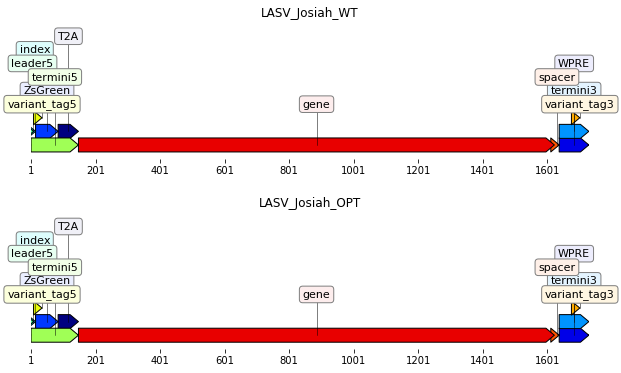

In [7]:
_ = targets.plot(ax_width=10)

We can also look at the featue parsing specifications as a dict or YAML string (here we do it as YAML string):

In [8]:
print(targets.feature_parse_specs('yaml'))

LASV_Josiah_WT: &id001
  query_clip5: 10
  query_clip3: 10
  termini5:
    filter:
      clip5: 10
      mutation_nt_count: 1
      mutation_op_count: null
      clip3: 0
    return: []
  termini3:
    filter:
      clip3: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
    return: []
  gene:
    filter:
      mutation_nt_count: 30
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - mutations
    - accuracy
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return: []
  index:
    filter:
      clip5: 3
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
    return:
    - sequence
  variant_tag5:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
  variant_tag3:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
LAS

## PacBio CCSs
We will align PacBio circular consensus sequences (CCSs) to the target.
First, we want to look at the CCSs.
A FASTQ file with these CCSs along with an associated report file were generated using the PacBio `ccs` program (see [here](https://github.com/PacificBiosciences/ccs) for details on `ccs`) using commands like the following (generates report file and BAM of CCSs):

    ccs --minLength 50 --maxLength 5000 \
        --minPasses 3  --minPredictedAccuracy 0.999 \
        --reportFile lasv_pilot_report.txt \
        --polish --numThreads 16 \
        lasv_pilot_subreads.bam lasv_pilot_ccs.bam
        
The BAM file was then converted to a FASTQ file using [samtools](http://www.htslib.org/) with a flag to retain the number of passes (`np`):

    samtools bam2fq -T np lasv_pilot_ccs.bam > lasv_pilot_ccs.fastq
    
Here is a data frame with the resulting FASTQ and BAM files:

In [9]:
run_names = ['lasv_pilot']
ccs_dir = 'input_files'
file_name = 'lasv_example'

pacbio_runs = pd.DataFrame(
            {'name': run_names,
             'report': [f"{ccs_dir}/{name}_report.txt" for name in run_names],
             'fastq': [f"{ccs_dir}/{file_name}_ccs.fastq"]
             })

pacbio_runs

,name,report,fastq
0,lasv_pilot,input_files/lasv_pilot_report.txt,input_files/lasv_example_ccs.fastq


We create a `Summaries` object for these CCSs:

In [10]:
ccs_summaries = alignparse.ccs.Summaries(pacbio_runs, ncpus=1)

Plot how many ZMWs yielded CCSs:

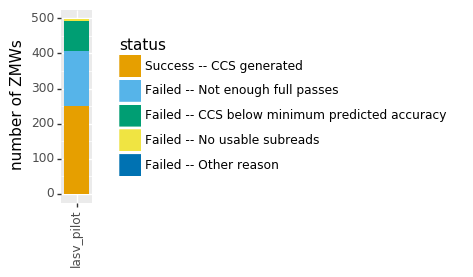

In [11]:
p = ccs_summaries.plot_zmw_stats()
_ = p.draw()

In [12]:
ccs_summaries.zmw_stats()

,name,status,number,fraction
0,lasv_pilot,Success -- CCS generated,250,0.4996
1,lasv_pilot,Failed -- Not enough full passes,157,0.3144
2,lasv_pilot,Failed -- CCS below minimum predicted accuracy,86,0.1720
3,lasv_pilot,Failed -- No usable subreads,6,0.0137
4,lasv_pilot,Failed -- Other reason,0,0.0000


Statistics on the CCSs (length, number of subread passes, accuracy):

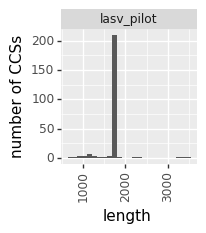

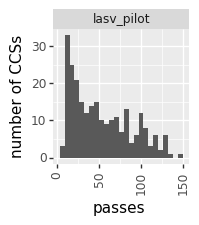

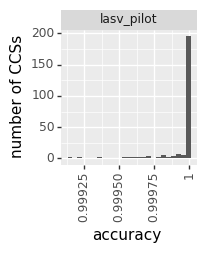

In [13]:
for stat in ['length', 'passes', 'accuracy']:
    if ccs_summaries.has_stat(stat):
        p = ccs_summaries.plot_ccs_stats(stat)
        _ = p.draw()
    else:
        print(f"No information available on CCS {stat}")

## Align CCSs to target
Now we use `minimap2` to align the CCSs to the target.

First, we create a `Mapper` object to run `minimap2`, using the options for codon-level deep mutational scanning:

In [14]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --secondary=no --cs


Now use this mapper to do the alignments to a SAM file.
First, add the names of the desired alignment files to our data frame:

In [15]:
pacbio_runs = pacbio_runs.assign(alignments=lambda x: outdir + x['name'] + '_alignments.sam')

pacbio_runs

,name,report,fastq,alignments
0,lasv_pilot,input_files/lasv_pilot_report.txt,input_files/lasv_example_ccs.fastq,./output_files/lasv_pilot_alignments.sam


Now use the mapper to actually align the FASTQ queries to the target:

In [16]:
for tup in pacbio_runs.itertuples(index=False):
    print(f"Aligning {tup.fastq} to create {tup.alignments}...")
    targets.align(queryfile=tup.fastq,
                  alignmentfile=tup.alignments,
                  mapper=mapper)

Aligning input_files/lasv_example_ccs.fastq to create ./output_files/lasv_pilot_alignments.sam...


These SAM files now contain the alignments along with the [`cs` tag](https://github.com/lh3/minimap2#cs), which contains details on the mutations:

In [17]:
for fname in pacbio_runs['alignments'][:1]:
    with pysam.AlignmentFile(fname) as f:
        a = next(f)
        print(f"First alignment in {fname} has `cs` tag:\n" + a.get_tag('cs'))

First alignment in ./output_files/lasv_pilot_alignments.sam has `cs` tag:
:8*ng*na*ng*na*nc*ng:19*nc:1667*na:28


## Parse the alignments
Now we use `Targets.parse_alignments` to parse the SAM files to get the information we specified for return.
This function returns a data frames (`readstats`) on the overall parsing stats, plus dicts keyed by the names of each target in `Targets` giving data frames on the aligned and filtered reads.
We concatenate the data frames for each PacBio run and then look at them together:

In [18]:
readstats = []
aligned = {targetname: [] for targetname in targets.target_names}
filtered = {targetname: [] for targetname in targets.target_names}

for run in pacbio_runs.itertuples():
    
    print(f"Parsing PacBio run {run.name}")
    run_readstats, run_aligned, run_filtered = targets.parse_alignment(run.alignments, filtered_cs=True)
    
    # when concatenating add the run name to keep track of runs for results
    readstats.append(run_readstats
                     .assign(run_name=run.name)
                     )
    for targetname in targets.target_names:
        aligned[targetname].append(run_aligned[targetname]
                                   .assign(run_name=run.name)
                                   )
        filtered[targetname].append(run_filtered[targetname]
                                    .assign(run_name=run.name)
                                    )
        
# now concatenate the data frames for each run
readstats = pd.concat(readstats, ignore_index=True, sort=False)
for targetname in targets.target_names:
    aligned[targetname] = pd.concat(aligned[targetname], ignore_index=True, sort=False)
    filtered[targetname] = pd.concat(filtered[targetname], ignore_index=True, sort=False)

Parsing PacBio run lasv_pilot


First lets look at the read stats:

From the known composition of the library, there should be more LASV_Josiah_OPT reads than LASV_Josiah_WT.

In [19]:
readstats

,category,count,run_name
0,filtered LASV_Josiah_WT,23,lasv_pilot
1,aligned LASV_Josiah_WT,84,lasv_pilot
2,filtered LASV_Josiah_OPT,31,lasv_pilot
3,aligned LASV_Josiah_OPT,112,lasv_pilot
4,unmapped,0,lasv_pilot


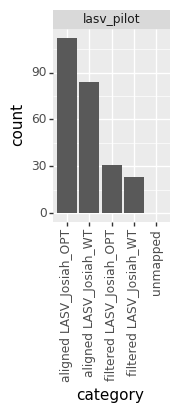

In [20]:
p = (
    ggplot(readstats, aes('category', 'count')) +
    geom_bar(stat='identity') +
    facet_wrap('~ run_name', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.5 * len(pacbio_runs), 2.5)
          )
    )
_ = p.draw()

Now look at the information on the filtered reads.
This is a bigger data frame, so we just look at the first few lines for the first target (of which there is only one anyway):

In [21]:
filtered[targets.target_names[0]].head()

,query_name,filter_reason,filter_cs,run_name
0,m54228_190605_190010/4194989/ccs,termini5 clip5,*nc*na*nc:19*nc:113,lasv_pilot
1,m54228_190605_190010/4260334/ccs,query_clip5,None,lasv_pilot
2,m54228_190605_190010/4260585/ccs,termini3 mutation_nt_count,:35*ag:20*ag:6*na:28,lasv_pilot
3,m54228_190605_190010/4391712/ccs,termini5 clip5,,lasv_pilot
4,m54228_190605_190010/4456843/ccs,termini3 clip3,,lasv_pilot


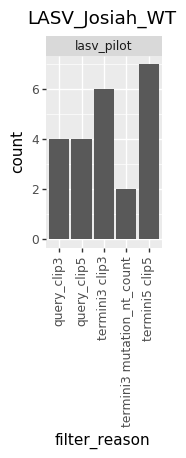

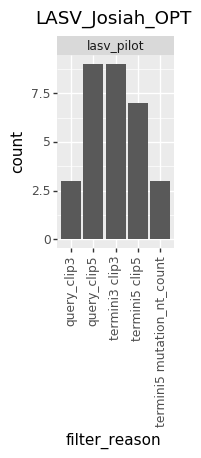

In [22]:
for targetname in targets.target_names:
    target_filtered = filtered[targetname]
    nreasons = target_filtered['filter_reason'].nunique()
    p = (
        ggplot(target_filtered, aes('filter_reason')) +
        geom_bar() +
        facet_wrap('~ run_name', nrow=1) +
        labs(title=targetname) +
        theme(axis_text_x=element_text(angle=90),
              figure_size=(0.3 * nreasons * len(pacbio_runs), 2.5),
              )
        )
    _ = p.draw()

## Error filtering

Before looking at the information for the validly aligned (not filtered) reads, it is important to get a sense of the error rate for these sequencing reads. 

These reads do not have barcodes on each initial viral entry protein plasmid, but we can use the 'gene_accuracy' information output from constructing the `ccs`s to examine accuracy. 

We will do this using a similar method to that implemented in the `recA_DMS.ipynb` example notebook. However, here we will plot the graphs for each target. 

We anticipate excluding all CCSs for which the error rate for either the gene or barcode is $>10^{-4}$.
We specify this cutoff below.

In [23]:
CBPALETTE = ('#E69F00', '#56B4E9', '#009E73', '#999999')

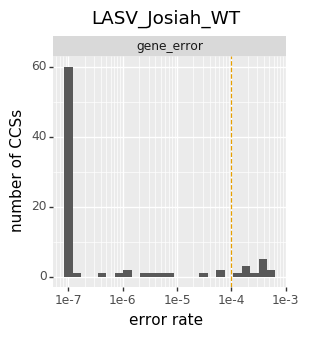

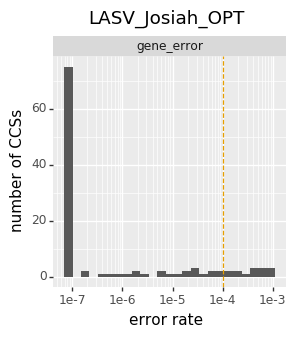

In [24]:
error_rate_floor = 1e-7  # error rates < this set to this
error_cutoff = 1e-4

for targetname in targets.target_names:
    aligned[targetname] = (
                  aligned[targetname]
                  .assign(
                          gene_error=lambda x: numpy.clip(1 - x['gene_accuracy'],
                                                          error_rate_floor, None)
                          )
                  )
    p = (
         ggplot(aligned[targetname]
                .melt(id_vars=['run_name'],
                      value_vars=['gene_error'],
                      var_name='feature_type', value_name='error rate'),
                aes('error rate')) +
         geom_histogram(bins=25) +
         geom_vline(xintercept=error_cutoff,
                    linetype='dashed',
                    color=CBPALETTE[0]) +
         facet_grid('~ feature_type') +
         theme(figure_size=(3, 3)) +
         labs(y=('number of CCSs'), title=(targetname)) +
         scale_x_log10()
         )

    _ = p.draw()

Store all reads with an error rate <1e-4 in new dataframes for retained sequences. 

We will use these retained sequences for further analyses.

In [25]:
retained = {targetname: [] for targetname in targets.target_names}
for targetname in targets.target_names:
    target_retained = aligned[targetname][aligned[targetname]['gene_error'] <= error_cutoff].reset_index(drop=True)
    retained[targetname] = target_retained

## Data analysis

Now we can examine our data in more detail. First, let's look at the first few entries in the data frame for the each target:

In [26]:
for target_name in targets.target_names:
    print(target_name)
    display(retained[target_name].head())

LASV_Josiah_WT


,query_name,query_clip5,query_clip3,gene_mutations,gene_accuracy,index_sequence,variant_tag5_sequence,variant_tag3_sequence,run_name,gene_error
0,m54228_190605_190010/4194436/ccs,0,0,,1.0,GGTATG,C,A,lasv_pilot,1.000000e-07
1,m54228_190605_190010/4194472/ccs,0,0,T572C,1.0,GGTATG,T,G,lasv_pilot,1.000000e-07
2,m54228_190605_190010/4194509/ccs,0,0,,1.0,GGTATG,C,A,lasv_pilot,1.000000e-07
3,m54228_190605_190010/4194553/ccs,0,0,,1.0,GGTATG,C,A,lasv_pilot,1.000000e-07
4,m54228_190605_190010/4194576/ccs,0,0,,1.0,AGACAC,T,G,lasv_pilot,1.000000e-07


LASV_Josiah_OPT


,query_name,query_clip5,query_clip3,gene_mutations,gene_accuracy,index_sequence,variant_tag5_sequence,variant_tag3_sequence,run_name,gene_error
0,m54228_190605_190010/4194382/ccs,0,0,,1.0,GAGACG,C,A,lasv_pilot,1.000000e-07
1,m54228_190605_190010/4194390/ccs,0,0,,1.0,ACGACC,C,A,lasv_pilot,1.000000e-07
2,m54228_190605_190010/4194399/ccs,0,0,,1.0,ACGACC,C,A,lasv_pilot,1.000000e-07
3,m54228_190605_190010/4194439/ccs,0,0,,1.0,ACGACC,T,G,lasv_pilot,1.000000e-07
4,m54228_190605_190010/4194445/ccs,0,0,,1.0,CTTCAC,T,G,lasv_pilot,1.000000e-07


As seen by the 'index_sequence' columns, each target here has 2 or 3 different indices that map to it. These indicies indicate different samples. 

We can then split these dataframes into sample-specific dataframes based on the known starting index sequences for each target. We will store these dataframes in a new dictionary, keyed by target and index.

In the process of making these separate dataframes, we will also keep track of how many reads for each target map to each index or don't map to an index (so have an 'invalid' index) and plot these counts.

In [27]:
indices = {'LASV_Josiah_WT': ['AGACAC', 'GGTATG'], 'LASV_Josiah_OPT': ['ACGACC', 'CTTCAC', 'GAGACG']}
target_idx_retained = {}
index_counts = {target: [] for target in indices}
index_counts_dfs = {}
for target_name in targets.target_names:
    for index in indices[target_name]:
        target_idx_retained[f"{target_name}_{index}"] = retained[target_name][retained[target_name]['index_sequence'] == index].reset_index(drop=True)
        index_counts[f"{target_name}"].append((index, len(target_idx_retained[f"{target_name}_{index}"])))
    index_counts[f"{target_name}"].append(('invalid', (len(retained[target_name]) - 
                                                          sum(idx_tup[1] for idx_tup in index_counts[target_name]))))
    index_counts_dfs[target_name] = pd.DataFrame(index_counts[target_name], columns=['index', 'count'])

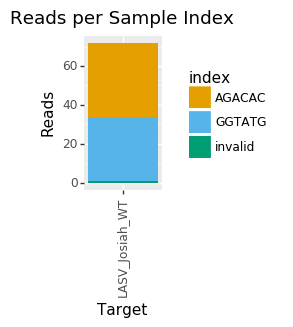

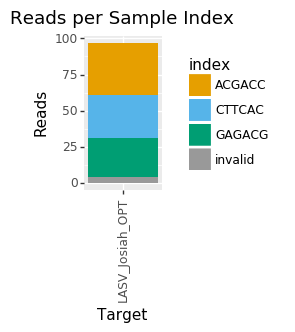

In [28]:
for target_name in targets.target_names:
    df = index_counts_dfs[target_name]
    df['target'] = [target_name]*len(df)
    index_count_plot = (ggplot(df, aes(x='target', y='count', fill='index')) +
                        geom_bar(stat='identity', position='stack') +
                        scale_fill_manual(values=CBPALETTE) +
                        theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
                        figure_size=(1, 2)) +
                        ylab('Reads') +
                        xlab('Target') +
                        ggtitle('Reads per Sample Index'))
    
    _ = index_count_plot.draw()

The two target-specific dataframes are now five target- and index-specific dataframes.

In [29]:
for target_idx in target_idx_retained:
    print(target_idx)
    display(target_idx_retained[target_idx].head())

LASV_Josiah_WT_AGACAC


,query_name,query_clip5,query_clip3,gene_mutations,gene_accuracy,index_sequence,variant_tag5_sequence,variant_tag3_sequence,run_name,gene_error
0,m54228_190605_190010/4194576/ccs,0,0,,1.0,AGACAC,T,G,lasv_pilot,1.000000e-07
1,m54228_190605_190010/4194612/ccs,0,0,,1.0,AGACAC,C,A,lasv_pilot,1.000000e-07
2,m54228_190605_190010/4194613/ccs,0,0,,1.0,AGACAC,T,G,lasv_pilot,1.000000e-07
3,m54228_190605_190010/4194760/ccs,0,0,,1.0,AGACAC,C,A,lasv_pilot,1.000000e-07
4,m54228_190605_190010/4194798/ccs,0,0,,1.0,AGACAC,C,A,lasv_pilot,1.000000e-07


LASV_Josiah_WT_GGTATG


,query_name,query_clip5,query_clip3,gene_mutations,gene_accuracy,index_sequence,variant_tag5_sequence,variant_tag3_sequence,run_name,gene_error
0,m54228_190605_190010/4194436/ccs,0,0,,1.0,GGTATG,C,A,lasv_pilot,1.000000e-07
1,m54228_190605_190010/4194472/ccs,0,0,T572C,1.0,GGTATG,T,G,lasv_pilot,1.000000e-07
2,m54228_190605_190010/4194509/ccs,0,0,,1.0,GGTATG,C,A,lasv_pilot,1.000000e-07
3,m54228_190605_190010/4194553/ccs,0,0,,1.0,GGTATG,C,A,lasv_pilot,1.000000e-07
4,m54228_190605_190010/4194689/ccs,0,0,,1.0,GGTATG,C,A,lasv_pilot,1.000000e-07


LASV_Josiah_OPT_ACGACC


,query_name,query_clip5,query_clip3,gene_mutations,gene_accuracy,index_sequence,variant_tag5_sequence,variant_tag3_sequence,run_name,gene_error
0,m54228_190605_190010/4194390/ccs,0,0,,1.0,ACGACC,C,A,lasv_pilot,1.000000e-07
1,m54228_190605_190010/4194399/ccs,0,0,,1.0,ACGACC,C,A,lasv_pilot,1.000000e-07
2,m54228_190605_190010/4194439/ccs,0,0,,1.0,ACGACC,T,G,lasv_pilot,1.000000e-07
3,m54228_190605_190010/4194534/ccs,0,0,C573T,1.0,ACGACC,T,G,lasv_pilot,1.000000e-07
4,m54228_190605_190010/4194541/ccs,0,0,G33A,1.0,ACGACC,C,A,lasv_pilot,1.000000e-07


LASV_Josiah_OPT_CTTCAC


,query_name,query_clip5,query_clip3,gene_mutations,gene_accuracy,index_sequence,variant_tag5_sequence,variant_tag3_sequence,run_name,gene_error
0,m54228_190605_190010/4194445/ccs,0,0,,1.000000,CTTCAC,T,G,lasv_pilot,1.000000e-07
1,m54228_190605_190010/4194501/ccs,0,0,,1.000000,CTTCAC,T,G,lasv_pilot,1.000000e-07
2,m54228_190605_190010/4194549/ccs,0,0,,0.999915,CTTCAC,T,G,lasv_pilot,8.484769e-05
3,m54228_190605_190010/4194575/ccs,0,0,,1.000000,CTTCAC,T,G,lasv_pilot,1.000000e-07
4,m54228_190605_190010/4194617/ccs,0,0,,1.000000,CTTCAC,C,A,lasv_pilot,1.000000e-07


LASV_Josiah_OPT_GAGACG


,query_name,query_clip5,query_clip3,gene_mutations,gene_accuracy,index_sequence,variant_tag5_sequence,variant_tag3_sequence,run_name,gene_error
0,m54228_190605_190010/4194382/ccs,0,0,,1.0,GAGACG,C,A,lasv_pilot,1.000000e-07
1,m54228_190605_190010/4194467/ccs,0,0,,1.0,GAGACG,T,G,lasv_pilot,1.000000e-07
2,m54228_190605_190010/4194491/ccs,0,0,,1.0,GAGACG,T,G,lasv_pilot,1.000000e-07
3,m54228_190605_190010/4194515/ccs,0,0,,1.0,GAGACG,C,A,lasv_pilot,1.000000e-07
4,m54228_190605_190010/4194584/ccs,0,0,,1.0,GAGACG,C,A,lasv_pilot,1.000000e-07


We can add mutation info for the genes in these targets.

In [30]:
for target_idx in target_idx_retained:
    target_idx_retained[target_idx] = alignparse.consensus.add_mut_info_cols(target_idx_retained[target_idx],
                                                                              mutation_col='gene_mutations',
                                                                              n_sub_col='n_gene_subs',
                                                                              n_indel_col='n_gene_indels')

We can then plot the number of reads for each sample that has each number of substitutions or indels to get a sense of if some smaples have more mutations than others and if substitutions or indels are more prevalent in these sequences. 

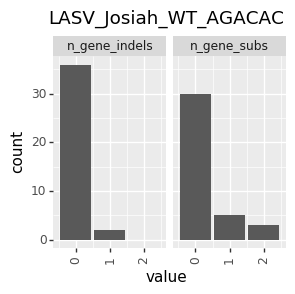

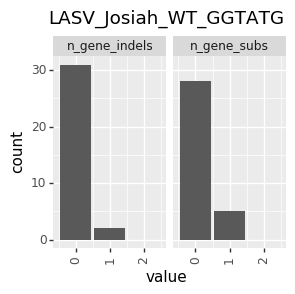

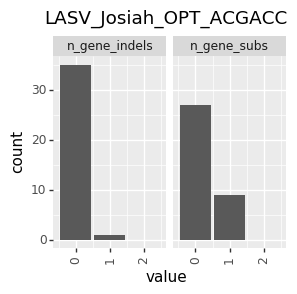

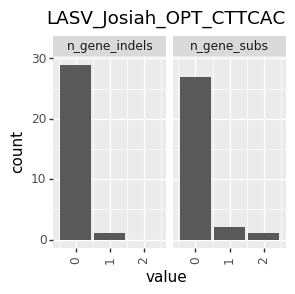

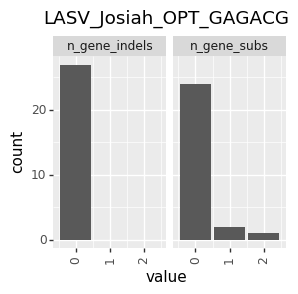

In [31]:
mut_cols = ['n_gene_subs', 'n_gene_indels']
for target_idx in target_idx_retained:
    target_idx_plot_muts = target_idx_retained[target_idx][mut_cols].melt()
    mut_counts_plot = (
                        ggplot(target_idx_plot_muts, aes('value')) +
                        geom_bar() +
                        facet_wrap('~ variable', ncol=2) +
                        xlim(-0.5, 2.5) +
                        labs(title=f"{target_idx}") +
                        theme(axis_text_x=element_text(angle=90),
                              figure_size=(3, 2.5),
                              )
    )
    _ = mut_counts_plot.draw()